In [52]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np




#TODO : 
# first plot the polygon points and the rafter lines 
# draw parallel lines (horizontal) 2 lines each polygon
# the parallel lines should be in the angle of the ridge_points
# mark the 
#REFACTOR:  
# the intersection points should be on the start and end of the plane with the modules
# the horizondal line should be 25% from the start and 25% from the end 



# portrait_formula : 9.8 * cos(pitch)
# landscape_formula : 22.6 * cos(pitch)


lancscape_coords = [
    [
        [822.5074776674039, 713.7043146606048],
        [819.2198652862223, 678.6280556504153],
        [765.9763062057334, 683.6184448478589],
        [769.2639185869148, 718.6947038580483],
    ],
    [
        [769.2639185869148, 718.6947038580483],
        [765.9763062057334, 683.6184448478589],
        [712.7327471252441, 688.6088340453025],
        [716.0203595064256, 723.6850930554917],
    ],
    [
        [716.0203595064256, 723.6850930554917],
        [712.7327471252441, 688.6088340453025],
        [659.489188044755, 693.5992232427461],
        [662.7768004259365, 728.6754822529352],
    ],
    [
        [662.7768004259365, 728.6754822529352],
        [659.489188044755, 693.5992232427461],
        [606.2456289642658, 698.5896124401888],
        [609.5332413454473, 733.6658714503786],
    ],
    [
        [609.5332413454473, 733.6658714503786],
        [606.2456289642658, 698.5896124401888],
        [553.0020698837767, 703.5800016376324],
        [556.2896822649582, 738.6562606478221],
    ],
    [
        [556.2896822649582, 738.6562606478221],
        [553.0020698837767, 703.5800016376324],
        [499.75851080328766, 708.5703908350761],
        [503.04612318446914, 743.6466498452655],
    ],
    [
        [503.04612318446914, 743.6466498452655],
        [499.75851080328766, 708.5703908350761],
        [446.5149517227985, 713.5607800325197],
        [449.80256410398, 748.6370390427089],
    ],
    [
        [772.5515309680961, 753.7709628682376],
        [769.2639185869147, 718.6947038580474],
        [716.0203595064256, 723.6850930554929],
        [719.307971887607, 758.761352065681],
    ],
    [
        [719.307971887607, 758.761352065681],
        [716.0203595064256, 723.6850930554929],
        [662.7768004259364, 728.6754822529356],
        [666.0644128071178, 763.7517412631245],
    ],
    [
        [666.0644128071178, 763.7517412631245],
        [662.7768004259364, 728.6754822529356],
        [609.5332413454472, 733.6658714503792],
        [612.8208537266287, 768.7421304605679],
    ],
    [
        [612.8208537266287, 768.7421304605679],
        [609.5332413454472, 733.6658714503792],
        [556.2896822649582, 738.6562606478228],
        [559.5772946461395, 773.7325196580114],
    ],
    [
        [559.5772946461395, 773.7325196580114],
        [556.2896822649582, 738.6562606478228],
        [503.04612318446914, 743.6466498452664],
        [506.3337355656505, 778.7229088554548],
    ],
    [
        [506.3337355656505, 778.7229088554548],
        [503.04612318446914, 743.6466498452664],
        [449.80256410398, 748.6370390427101],
        [453.09017648516135, 783.7132980528982],
    ],
    [
        [775.8391433492775, 788.8472218784269],
        [772.551530968096, 753.7709628682369],
        [719.3079718876068, 758.7613520656805],
        [722.5955842687883, 793.8376110758703],
    ],
    [
        [722.5955842687883, 793.8376110758703],
        [719.3079718876068, 758.7613520656805],
        [666.0644128071176, 763.7517412631241],
        [669.3520251882992, 798.8280002733138],
    ],
    [
        [669.3520251882992, 798.8280002733138],
        [666.0644128071176, 763.7517412631241],
        [612.8208537266286, 768.7421304605668],
        [616.10846610781, 803.8183894707572],
    ],
    [
        [616.10846610781, 803.8183894707572],
        [612.8208537266286, 768.7421304605668],
        [559.5772946461394, 773.7325196580105],
        [562.8649070273209, 808.8087786682007],
    ],
    [
        [562.8649070273209, 808.8087786682007],
        [559.5772946461394, 773.7325196580105],
        [506.33373556565033, 778.7229088554541],
        [509.62134794683186, 813.7991678656441],
    ],
    [
        [509.62134794683186, 813.7991678656441],
        [506.33373556565033, 778.7229088554541],
        [453.0901764851611, 783.7132980528977],
        [456.3777888663427, 818.7895570630875],
    ],
    [
        [779.1267557304589, 823.9234808886162],
        [775.8391433492774, 788.8472218784282],
        [722.5955842687882, 793.8376110758709],
        [725.8831966499697, 828.9138700860597],
    ],
    [
        [725.8831966499697, 828.9138700860597],
        [722.5955842687882, 793.8376110758709],
        [669.3520251882992, 798.8280002733145],
        [672.6396375694806, 833.904259283503],
    ],
    [
        [672.6396375694806, 833.904259283503],
        [669.3520251882992, 798.8280002733145],
        [616.1084661078099, 803.8183894707572],
        [619.3960784889914, 838.8946484809466],
    ],
    [
        [619.3960784889914, 838.8946484809466],
        [616.1084661078099, 803.8183894707572],
        [562.8649070273208, 808.8087786682008],
        [566.1525194085023, 843.88503767839],
    ],
    [
        [566.1525194085023, 843.88503767839],
        [562.8649070273208, 808.8087786682008],
        [509.62134794683175, 813.7991678656435],
        [512.9089603280132, 848.8754268758335],
    ],
    [
        [512.9089603280132, 848.8754268758335],
        [509.62134794683175, 813.7991678656435],
        [456.3777888663426, 818.7895570630876],
        [459.6654012475241, 853.8658160732768],
    ],
    [
        [675.9272499506619, 868.9805182936924],
        [672.6396375694804, 833.904259283503],
        [619.3960784889914, 838.8946484809476],
        [622.6836908701728, 873.9709074911358],
    ],
    [
        [622.6836908701728, 873.9709074911358],
        [619.3960784889914, 838.8946484809476],
        [566.1525194085023, 843.8850376783912],
        [569.4401317896836, 878.9612966885793],
    ],
    [
        [569.4401317896836, 878.9612966885793],
        [566.1525194085023, 843.8850376783912],
        [512.9089603280131, 848.8754268758339],
        [516.1965727091946, 883.9516858860227],
    ],
    [
        [516.1965727091946, 883.9516858860227],
        [512.9089603280131, 848.8754268758339],
        [459.66540124752396, 853.8658160732771],
        [462.95301362870543, 888.9420750834661],
    ],
]


portrait_corods = [
    [
        [842.3775545539658, 730.1688379146426],
        [837.387165356522, 676.9252788341528],
        [802.3109063463328, 680.2128912153348],
        [807.3012955437765, 733.456450295824],
    ],
    [
        [807.3012955437765, 733.456450295824],
        [802.3109063463328, 680.2128912153348],
        [767.2346473361434, 683.500503596515],
        [772.2250365335872, 736.7440626770053],
    ],
    [
        [772.2250365335872, 736.7440626770053],
        [767.2346473361434, 683.500503596515],
        [732.1583883259543, 686.7881159776971],
        [737.1487775233979, 740.0316750581867],
    ],
    [
        [737.1487775233979, 740.0316750581867],
        [732.1583883259543, 686.7881159776971],
        [697.082129315765, 690.0757283588782],
        [702.0725185132086, 743.319287439368],
    ],
    [
        [702.0725185132086, 743.319287439368],
        [697.082129315765, 690.0757283588782],
        [662.0058703055756, 693.3633407400603],
        [666.9962595030192, 746.6068998205494],
    ],
    [
        [666.9962595030192, 746.6068998205494],
        [662.0058703055756, 693.3633407400603],
        [626.9296112953864, 696.6509531212414],
        [631.92000049283, 749.8945122017307],
    ],
    [
        [631.92000049283, 749.8945122017307],
        [626.9296112953864, 696.6509531212414],
        [591.853352285197, 699.9385655024225],
        [596.8437414826407, 753.182124582912],
    ],
    [
        [596.8437414826407, 753.182124582912],
        [591.853352285197, 699.9385655024225],
        [556.7770932750077, 703.2261778836037],
        [561.7674824724513, 756.4697369640934],
    ],
    [
        [561.7674824724513, 756.4697369640934],
        [556.7770932750077, 703.2261778836037],
        [521.7008342648185, 706.5137902647857],
        [526.6912234622621, 759.7573493452747],
    ],
    [
        [526.6912234622621, 759.7573493452747],
        [521.7008342648185, 706.5137902647857],
        [486.6245752546291, 709.8014026459668],
        [491.6149644520728, 763.0449617264561],
    ],
    [
        [491.6149644520728, 763.0449617264561],
        [486.6245752546291, 709.8014026459668],
        [451.54831624443983, 713.0890150271489],
        [456.53870544188345, 766.3325741076375],
    ],
    [
        [777.2154257310307, 789.9876217574945],
        [772.225036533587, 736.7440626770049],
        [737.1487775233978, 740.031675058186],
        [742.1391667208414, 793.2752341386758],
    ],
    [
        [742.1391667208414, 793.2752341386758],
        [737.1487775233978, 740.031675058186],
        [702.0725185132084, 743.3192874393671],
        [707.0629077106521, 796.5628465198572],
    ],
    [
        [707.0629077106521, 796.5628465198572],
        [702.0725185132084, 743.3192874393671],
        [666.9962595030191, 746.6068998205492],
        [671.9866487004628, 799.8504589010385],
    ],
    [
        [671.9866487004628, 799.8504589010385],
        [666.9962595030191, 746.6068998205492],
        [631.9200004928297, 749.8945122017303],
        [636.9103896902734, 803.1380712822198],
    ],
    [
        [636.9103896902734, 803.1380712822198],
        [631.9200004928297, 749.8945122017303],
        [596.8437414826406, 753.1821245829115],
        [601.8341306800842, 806.4256836634012],
    ],
    [
        [601.8341306800842, 806.4256836634012],
        [596.8437414826406, 753.1821245829115],
        [561.7674824724513, 756.4697369640926],
        [566.7578716698949, 809.7132960445825],
    ],
    [
        [566.7578716698949, 809.7132960445825],
        [561.7674824724513, 756.4697369640926],
        [526.691223462262, 759.7573493452746],
        [531.6816126597056, 813.0009084257639],
    ],
    [
        [531.6816126597056, 813.0009084257639],
        [526.691223462262, 759.7573493452746],
        [491.6149644520726, 763.0449617264558],
        [496.60535364951625, 816.2885208069453],
    ],
    [
        [496.60535364951625, 816.2885208069453],
        [491.6149644520726, 763.0449617264558],
        [456.53870544188334, 766.3325741076378],
        [461.52909463932696, 819.5761331881266],
    ],
    [
        [782.2058149284741, 843.2311808379836],
        [777.2154257310305, 789.9876217574938],
        [742.139166720841, 793.2752341386749],
        [747.1295559182847, 846.518793219165],
    ],
    [
        [747.1295559182847, 846.518793219165],
        [742.139166720841, 793.2752341386749],
        [707.0629077106519, 796.5628465198579],
        [712.0532969080955, 849.8064056003464],
    ],
    [
        [712.0532969080955, 849.8064056003464],
        [707.0629077106519, 796.5628465198579],
        [671.9866487004625, 799.850458901039],
        [676.9770378979061, 853.0940179815277],
    ],
    [
        [676.9770378979061, 853.0940179815277],
        [671.9866487004625, 799.850458901039],
        [636.9103896902732, 803.1380712822192],
        [641.9007788877168, 856.381630362709],
    ],
    [
        [641.9007788877168, 856.381630362709],
        [636.9103896902732, 803.1380712822192],
        [601.834130680084, 806.4256836634013],
        [606.8245198775276, 859.6692427438903],
    ],
    [
        [606.8245198775276, 859.6692427438903],
        [601.834130680084, 806.4256836634013],
        [566.7578716698946, 809.7132960445815],
        [571.7482608673383, 862.9568551250717],
    ],
    [
        [571.7482608673383, 862.9568551250717],
        [566.7578716698946, 809.7132960445815],
        [531.6816126597053, 813.0009084257626],
        [536.672001857149, 866.244467506253],
    ],
    [
        [536.672001857149, 866.244467506253],
        [531.6816126597053, 813.0009084257626],
        [496.60535364951613, 816.2885208069456],
        [501.5957428469597, 869.5320798874344],
    ],
    [
        [501.5957428469597, 869.5320798874344],
        [496.60535364951613, 816.2885208069456],
        [461.5290946393267, 819.5761331881258],
        [466.51948383677035, 872.8196922686158],
    ],
]




ridge_points = [
    [[885.4151069433566, 658.1430376552173],
    [427.2352488971326, 701.0871205371207]],
]
eve_points = [
    [[450.19415245936176, 917.8049341504471],
    [808.552690669807, 866.8712544533059]],
]

after_set_back_points = [
    [442.8906323590193, 713.9004786648696],
    [462.7811529560261, 901.6546596835915],
    [793.4966910830967, 854.6498935241202],
    [786.4704153383078, 748.2001587268123],
    [878.043673226332, 739.2375401118809],
    [872.4634243667117, 673.6376664529721],
    [442.8906323590193, 713.9004786648696],
]



rafter_tip_points = [
    [386.31026382726816, 809.369948617736],
    [405.2722055074519, 809.2971580546644],
    [424.2341471876356, 809.2243674915926],
    [443.1960888678191, 809.1515769285209],
    [462.15803054800284, 809.0787863654491],
    [481.1199722281865, 809.0059958023775],
    [500.08191390837015, 808.9332052393057],
    [519.0438555885538, 808.860414676234],
    [538.0057972687374, 808.7876241131622],
    [556.967738948921, 808.7148335500905],
    [575.9296806291047, 808.6420429870188],
    [594.8916223092883, 808.5692524239471],
    [613.853563989472, 808.4964618608753],
    [632.8155056696557, 808.4236712978036],
    [651.7774473498393, 808.350880734732],
    [670.7393890300231, 808.2780901716602],
    [689.7013307102067, 808.2052996085885],
    [708.6632723903903, 808.1325090455167],
    [727.6252140705739, 808.059718482445],
    [746.5871557507575, 807.9869279193733],
    [765.5490974309412, 807.9141373563016],
    [784.5110391111248, 807.8413467932298],
    [803.4729807913085, 807.7685562301581],
    [822.434922471492, 807.6957656670864],
    [841.3968641516757, 807.6229751040147],
    [860.3588058318593, 807.550184540943],
    [879.3207475120429, 807.4773939778712],
]



rafter_lines = [
    [[866.5399899872009, 659.9121564253597], [875.338800284868, 753.7885971971191]],
    [[847.6648730310452, 661.6812751955022], [856.470951752996, 755.6352643833216]],
    [[828.7897560748895, 663.4503939656446], [837.6031032211243, 757.481931569524]],
    [[809.9146391187339, 665.219512735787], [818.7352546892527, 759.3285987557256]],
    [[791.0395221625782, 666.9886315059294], [805.6446941332941, 822.8144210258861]],
    [[772.1644052064225, 668.7577502760719], [790.967365465647, 869.3706655899614]],
    [[753.2892882502668, 670.5268690462143], [772.1767533211356, 872.041384767077]],
    [[734.4141712941112, 672.2959878163567], [753.3861411766243, 874.7121039441926]],
    [[715.5390543379556, 674.0651065864992], [734.5955290321131, 877.3828231213082]],
    [[696.6639373817998, 675.8342253566416], [715.8049168876015, 880.0535422984238]],
    [[677.7888204256442, 677.603344126784], [697.0143047430903, 882.7242614755394]],
    [[658.9137034694885, 679.3724628969264], [678.2236925985789, 885.394980652655]],
    [[640.0385865133328, 681.1415816670689], [659.4330804540676, 888.0656998297707]],
    [[621.1634695571772, 682.9107004372113], [640.6424683095562, 890.7364190068863]],
    [[602.2883526010215, 684.6798192073537], [621.8518561650449, 893.4071381840018]],
    [[583.4132356448658, 686.4489379774961], [603.0612440205334, 896.0778573611175]],
    [[564.5381186887103, 688.2180567476386], [584.2706318760222, 898.748576538233]],
    [[545.6630017325544, 689.987175517781], [565.4800197315108, 901.4192957153487]],
    [[526.7878847763989, 691.7562942879234], [546.6894075869994, 904.0900148924643]],
    [[507.9127678202432, 693.5254130580659], [527.8987954424881, 906.7607340695799]],
    [[489.03765086408754, 695.2945318282083], [509.1081832979767, 909.4314532466955]],
    [[470.1625339079319, 697.0636505983507], [490.31757115346545, 912.1021724238111]],
    [[451.2874169517762, 698.8327693684931], [471.52695900895407, 914.7728916009268]],
    [[432.4122999956206, 700.6018881386356], [452.73634686444274, 917.4436107780423]],
]



row_information = {
    "row_1": {
        "first_row": [
            [503.04612318446914, 743.6466498452655],
            [499.75851080328766, 708.5703908350761],
            [446.5149517227985, 713.5607800325197],
            [449.80256410398, 748.6370390427089],
        ],
        "last_row": [
            [822.5074776674039, 713.7043146606048],
            [819.2198652862223, 678.6280556504153],
            [765.9763062057334, 683.6184448478589],
            [769.2639185869148, 718.6947038580483],
        ],
    },
}



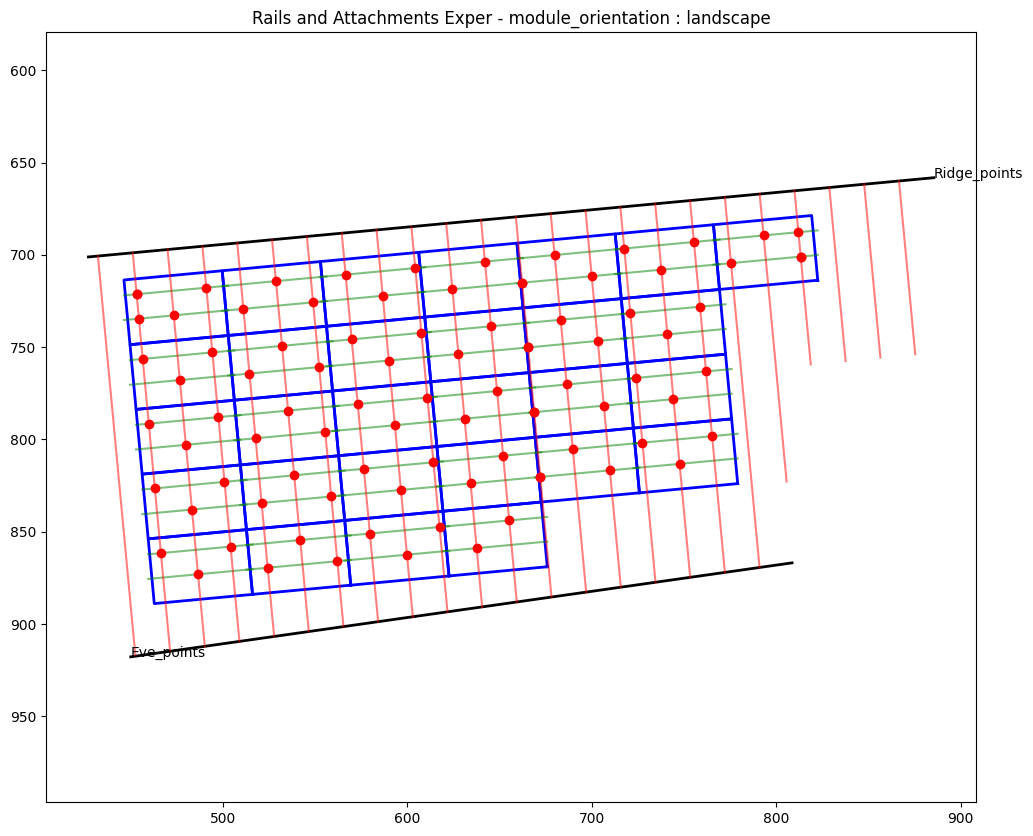

In [ ]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np

import contextlib
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
from dataclasses import field





@dataclass
class PlaceRailsAndAttachment:
    polygon_coords: list
    ridge_points: list
    eve_points: list
    rafter_lines: list
    row_count : int
    module_orientation: Optional[str] = None
    

    
    # optional points
    polygon_min : Optional[List] = field(default_factory=list)
    polygon_max : Optional[List] = field(default_factory=list)
    vertical_lines: Optional[List[LineString]] = field(default_factory=list)
    horizontal_lines: Optional[List[LineString]] = field(default_factory=list)
    new_ridge_lines: Optional[List[LineString]] = field(default_factory=list)
    new_eve_lines: Optional[List[LineString]] = field(default_factory=list)
    rail_lines : Optional[List[LineString]] = field(default_factory=list)
    polygons: Optional[List[Polygon]] = None

    def __post_init__(self):
        self.vertical_lines = self.line_string_maker(self.rafter_lines , set_rail_line = True)
        self.new_ridge_lines = self.line_string_maker(self.ridge_points)
        self.new_eve_lines = self.line_string_maker(self.eve_points)
        self.polygons = [Polygon(coords) for coords in self.polygon_coords]

    def polygon_boundaries(self) -> Tuple:
        polygon_coords = self.polygon_coords
        min_x = min(min(x for x, y in poly) for poly in polygon_coords)
        max_x = max(max(x for x, y in poly) for poly in polygon_coords)
        min_y = min(min(y for x, y in poly) for poly in polygon_coords)
        max_y = max(max(y for x, y in poly) for poly in polygon_coords)
        return min_x, max_x, min_y, max_y

    def line_string_maker(self, line_segment: list , set_rail_line : bool = False) -> list:
        lines = []
        for segment in line_segment:
            start, end = segment
            line = LineString([(start[0], start[1]), (end[0], end[1])])
            if set_rail_line:
                self.rail_lines.append(
                    [
                        {
                            "x1" : start[0],
                            "y1" : start[1],
                        },
                        {
                            "x2" : end[0],
                            "y2" : end[1],
                        }
                    ]
                )
            lines.append(line)
        return lines

    def ridge_angle(self):
        with contextlib.suppress(ValueError):
            ridge_coords = self.ridge_points[0]
            ridge_start, ridge_end = ridge_coords
            ridge_dx = ridge_end[0] - ridge_start[0]
            ridge_dy = ridge_end[1] - ridge_start[1]
            return np.arctan2(ridge_dy, ridge_dx)
        return None

    def rafter_coords(self):
        rafter_x_coords = [coord for line in self.rafter_lines for point in line for coord in [point[0]]]
        min_rafter_x = min(rafter_x_coords)
        max_rafter_x = max(rafter_x_coords)
        return min_rafter_x, max_rafter_x  



    def generate_horizontal_lines(self) -> None:
        ridge_angle = self.ridge_angle()
        for  poly_idx , polygon in enumerate(self.polygons):
            # Get x and y ranges for the polygon
            """ this is drawing parallel lines per polygon nased on the ridge angle axis"""
            
            x_coords, y_coords = polygon.exterior.xy
            poly_min_x = min(x_coords)
            poly_max_x = max(x_coords)
            poly_min_y = min(y_coords)
            poly_max_y = max(y_coords)
            

            
            self.polygon_min.append({"x" : poly_min_x, "y" : poly_min_y})
            self.polygon_max.append({"x" : poly_max_x, "y" : poly_max_y})
            # self.polygon_min_x.append(min(poly_min_x))
            # self.polygon_max_x.append(max(poly_max_x))
            # Calculate height range and evenly spaced y-positions (33.33% and 66.66%)
            height_range = poly_max_y - poly_min_y
            y1 = poly_min_y + 0.3333 * height_range  # ~33.33% from bottom
            y2 = poly_min_y + 0.6666 * height_range  # ~66.66% from bottom
            
            # Calculate line length based on polygon's x-range and ridge angle
            line_length = (poly_max_x - poly_min_x) / np.cos(ridge_angle)  if np.cos(ridge_angle)  != 0 else 0
            
            # Create lines with ridge angle starting at polygon's min_x
            # changed the line angle based on the ridge angle 
            # FIXME :  fix required on the line to cover all to end of the rafter tips
            # REFACTORTHIS : need to change the angle based on both the ridge and eve angle 
            x_start = poly_min_x
            x_end = x_start + line_length * np.cos(ridge_angle)
            
            line1_start = (x_start, y1)
            line1_end = (x_end, y1 + line_length * np.sin(ridge_angle))
            line2_start = (x_start, y2)
            line2_end = (x_end, y2 + line_length * np.sin(ridge_angle) )
            self.horizontal_lines.append(LineString([line1_start, line1_end]))
            self.horizontal_lines.append(LineString([line2_start, line2_end]))
    


    def first_and_last_polygon_attachmenting(self , polygon_intersections : dict) -> list :
        first_and_last_points : list = []
        for row_idx in range(self.row_count):
            row_key = f'row_{row_idx + 1}'
            row_data = row_information.get(row_key)
            if not row_data:
                continue
            first_row_coords = row_data.get('first_row')
            last_row_coords = row_data.get('last_row')

            first_row_polygon = Polygon(first_row_coords) if first_row_coords else None
            last_row_polygon = Polygon(last_row_coords) if last_row_coords else None

            first_poly_idx = None
            last_poly_idx = None
            for poly_idx, poly in enumerate(self.polygons):
                if first_row_polygon and poly == first_row_polygon:
                    first_poly_idx = poly_idx
                if last_row_polygon and poly == last_row_polygon:
                    last_poly_idx = poly_idx

            # for the first polygons 
            if first_poly_idx is not None and first_poly_idx in polygon_intersections:
                sorted_first_points = sorted(polygon_intersections[first_poly_idx], key=lambda point: point[0])
                if sorted_first_points:
                    first_point = sorted_first_points[0]
                    second_point = sorted_first_points[1]
                    first_and_last_points.append(first_point)
                    first_and_last_points.append(second_point)

            # for the last polygonds
            if last_poly_idx is not None and last_poly_idx in polygon_intersections:
                sorted_last_points = sorted(polygon_intersections[last_poly_idx], key=lambda point: point[0])
                if sorted_last_points:
                    last_point = sorted_last_points[-1]
                    first_and_last_points.append(last_point)
                    first_and_last_points.append(sorted_last_points[-2])

        return first_and_last_points

    def h_v_intersections(self) -> list:
        h_v_intersections_points: list = []

        polygon_intersections = {poly_idx: [] for poly_idx in range(len(self.polygons))}

       
        for poly_idx, polygon in enumerate(self.polygons):
            for h_idx, h_line in enumerate(self.horizontal_lines):
                for v_idx, v_line in enumerate(self.vertical_lines):
                    h_v_point = h_line.intersection(v_line)
                    if not h_v_point.is_empty and polygon.contains(h_v_point):
                        polygon_intersections[poly_idx].append((h_v_point.x, h_v_point.y))
                        if (h_idx % 2 == 0 and v_idx % 2 == 0) or (h_idx % 2 == 1 and v_idx % 2 == 1):
                            h_v_intersections_points.append((h_v_point.x, h_v_point.y))


        first_and_last_point_extends = self.first_and_last_polygon_attachmenting(polygon_intersections)
        return h_v_intersections_points + first_and_last_point_extends 
    



    def plot(self):
        plt.figure(figsize=(12,10))

        h_v_intersection_points  =  self.h_v_intersections()

        
        # Plot polygons
        for polygon in self.polygons:
            x, y = polygon.exterior.xy
            plt.plot(x, y, 'b-', linewidth=2)

        # Plot ridge lines
        for line in self.new_ridge_lines:  
            x, y = line.xy
            plt.plot(x, y, 'k-', linewidth=2)
            plt.text(x[0], y[0], 'Ridge_points', fontsize=10)

        # Plot eve lines
        for line in self.new_eve_lines: 
            x, y = line.xy
            plt.plot(x, y, 'k-', linewidth=2)
            plt.text(x[0], y[0], 'Eve_points', fontsize=10)

        # Plot horizontal lines (rail lines)
        for line in self.horizontal_lines:
            x, y = line.xy
            plt.plot(x, y, 'g-', alpha=0.5)

        # Plot vertical lines (rafter lines)
        for line in self.vertical_lines:
            x, y = line.xy
            self.rail_lines.append({
                "x" : x.tolist()[0] ,
                "y" : y.tolist()[0]
            })
            plt.plot(x, y, 'r-', alpha=0.5)

        # plot h-v lines
        for point in h_v_intersection_points:
            plt.plot(point[0], point[1], 'ro', markersize=6)

        # # Set plot limits
        # COMMENT: add plot limits to the fig size (not recommended for the getting points for canvas draw)
        x_values = [coord[0] for poly in self.polygon_coords for coord in poly] + \
                  [seg[0][0] for seg in self.rafter_lines] + [seg[1][0] for seg in self.rafter_lines]
        y_values = [coord[1] for poly in self.polygon_coords for coord in poly] + \
                  [seg[0][1] for seg in self.rafter_lines] + [seg[1][1] for seg in self.rafter_lines]

        plt.xlim(min(x_values) - 50, max(x_values) + 50)
        plt.ylim(min(y_values) - 50, max(y_values) + 50)

        plt.title(f"Rails and Attachments Exper - module_orientation : {module_orientation}")
        plt.grid(False)
        plt.axis('equal')
        plt.gca().invert_yaxis()
        plt.show()
        return h_v_intersection_points

    def convert_to_points(self , lines) -> List[Dict[str, float]]:
        points = []
        for line in lines:
            x_coords, y_coords = line.xy
            points.append({"x": x_coords[0], "y": y_coords[0]})
            points.append({"x": x_coords[1], "y": y_coords[1]})
        return points


    def main(self) -> Dict: 
        self.polygon_boundaries()
        self.rafter_coords()
        self.generate_horizontal_lines() 
        intersection_points = self.plot()
        return {
            "rail_lines" : self.rail_lines,
            "rails_rafter_intersection" : [{"x" :item[0] , "y" : item[1]} for item in intersection_points ],
        }
    
module_orientation = "landscape"
polygon_coords = lancscape_coords if module_orientation == 'landscape' else portrait_corods

object = PlaceRailsAndAttachment(
    polygon_coords=polygon_coords,
    ridge_points=ridge_points,
    eve_points=eve_points,
    rafter_lines=rafter_lines,
    module_orientation='landscape',
    row_count = 5
).main()



# print(object['rail_lines'])
# print(object['rails_rafter_intersection'])


# if __name__ == '__main__':
#     PlaceRailsAndAttachment(
#         polygon_coords=polygon_coords,
#         ridge_points=ridge_points,
#         eve_points=eve_points,
#         rafter_lines=rafter_lines,
#         firesetback_points=after_set_back_points,
#         module_orientation='landscape'
#     ).main()




